In [1]:
import pandas as pd
import numpy as np
import pyreadr
import math
import random
import os
import csv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import time

## Parte I

### Pregunta 1

| Marca – modelo | Precio ($) | Bus Memoria | Memoria | Velocidad de Boost (memoria) | Velocidad Game | Velocidad Bandwidth |
| --- | --- | --- | --- | --- | --- | --- |
| MSI Radeon  | 515 | 128 bits | 8GB GDDR6 | 2602 MHz | 2413 MHz |  | 
| RX 6600 XT |       |         |           |         |          |           |
| BIOSTAR RADEON RX560  | 515 | 128 bits | 4GB DDR5 | 1175 MHz | 1275MHz |  |
| PNY GEFORCE RTX 3060 | 550 | 192 bits | 12GB GDDR6 | 1777 MHz |  | 360 GB | 

Fuentes:
- https://cyccomputer.pe/amd-radeon/21256-msi-radeon-rx-6600-xt-mech-2x-8gb-gddr6-128bits-oc-pn912-v502-015.html
- https://cyccomputer.pe/amd-radeon/20821-biostar-radeon-rx560-4gb-ddr5-128bits-gaming-pnva5615rf41-tbhra-bs2.html
- https://cyccomputer.pe/nvidia-geforce-rtx/21359-pny-geforce-rtx-3060-12gb-gddr6-192bits-xlr8-gaming-oem-pngmr3061n4jcet1bktp.html

Para realizar computación en paralelo, la mejor opción a tomar en cuenta es la MSI Radeon; ya que, cuesta un poco menos que la PNY y tiene varias ventajas, entre estas se tiene que la MSI posee un mayor rendimiento en velocidad de reloj del procesador y de memoria GPU, a pesar de que se está sacrificando un poco de potencia en el procesamiento de la GPU, lo que permite un rendimiento superior para la ejecución de computación en paralelo. 

Por otra parte, la MSI supera en velocidad de la memoria a los otros modelos, con lo cual se incrementa el rendimiento en aplicaciones ya que tienen mayores registros de velocidad a diferencia de la PNY. También, se puede atribuir a ambas un similar funcionamiento de las tarjetas gráficas, ya que ambas poseen una misma anchura del bus de memoria, con lo cual tienen similar capacidad de soportar más datos por ciclo. Finalmente, se puede concluir que la MSI debería ser la tarjeta gráfica por elegir, ya que tiene un precio no muy distante de la PNY y tiene varias características a favor.


### Pregunta 2

Good Data no será reemplazado por Big Data o viceversa, ya que la estructura para obtener la información es diferente. Incluso en Couper (2013) se menciona que las nuevas formas de obtener data son interesantes, pero no se debe descartar los métodos tradicionales como las encuestas. Sin embargo, si se pueden complementar porque ambas forman parte de las herramientas que usa la ciencia de datos para inferir sobre la realidad. O como señala Ng (2022) se debería buscar tener datos de mejor calidad que partan por una selección basada en big data y las técnicas de IA correspondiente que permita mejorar la selección de pequeños datos.

Como ejemplo, se puede entender la información que proviene de las encuestas, ya que son una herramienta potente para levantar información y entender el mundo real, aunque no es la única herramienta. En Couper (2013) se llama una trampa a la idea de pensar que solo las encuestas nos ofrecen la mejor manera de recopilar información. De ahí resulta el Big Data y su facilidad para obtener los datos, los mismos que deben ser parte de un aprendizaje previo y ese redondeo al promedio conocido. Aplicado a la realidad que acabamos de pasar, es el uso de big data por el COVID-19, que finalmente dio lugar a Good data, pues permitió crear modelos de aprendizaje automático referente a trazabilidad del virus u otras aplicaciones de mejora de modelos epidemiológicos.

Otro ejemplo, las empresas en todo el mundo han desbordado sus bancos de datos y se han convertido en big data. Desde las cuentas de redes sociales hasta la cadena de suministro y los datos de gastos, las empresas tienen un acceso ilimitado. Pero con más información no necesariamente mejora la calidad del análisis, ya que la recopilación de datos es solo el primer paso. La gestión de datos, junto con el análisis de big data, lo ayudará a extraer los datos útiles y relevantes de las grandes cantidades de información disponible, y ponerlos en uso para generar valor y productividad para su negocio. Esto último es un claro ejemplo de good data.

### Pregunta 3

Al momento de importar nuestra base de datos, nuestras variables fueron importadas como de tipo 'O'. Inicialmente, tratamos de convertirlas en numéricas para poder realizar cálculos. Sin embargo, tuvimos dificultades realizando ello. Por ende, publicamos nuestro problema en Stackoverflow.

https://stackoverflow.com/questions/72828144/how-can-i-convert-an-object-variable-with-nan-into-an-int-variable-in-python

## Parte II

### Pregunta 1

El presente trabajo busca predecir si es que una mujer en edad fértil (15 a 49 años) en Perú sufre de algún tipo de violencia (emocional, física o sexual) por parte de su esposo/compañero. Para esto, se hará uso de la Encuesta Demográfica y de Salud Familiar (ENDES).

El módulo en el que se encuentran las variables de mayor interés es el de “Violencia Familiar”, el cual es ejecutado de manera continua desde 2008 . Las preguntas de este módulo son aplicadas aleatoriamente a una mujer por hogar que se encuentre en edad fértil (de 15 a 49 años). De este módulo, se construirá la variable target.

La variable target es una dummy que indica si es que la mujer ha sufrido violencia por parte de su esposo/compañero. Para la construcción del target, se hace uso de 4 variables (D104, D106, D107, D108). Si es que alguna de estas variables toma el valor de 1, entonces la mujer ha sido víctima de al menos algún tipo de violencia.

D104: Hubo violencia emocional | 0=No, 1=Sí

D106: Experimentó cualquier violencia física menos severa | 0=No, 1=Sí

D107: Experimentó cualquier violencia física severa | 0=No, 1=Sí

D108: Experimentó cualquier violencia sexual | 0=No, 1=Sí

En cuanto a las variables predictoras, se han considerado las siguientes:

* SREGION: Región Natural (Categórica)
* S108N: Nivel educativo (Categórica)
* S119: Idioma o lengua materna (Categórica)
* S119D: Etnicidad (Categórica)
* V213: Está embarazada (Dummy)
* V501: Estado conyugal actual (Categórica)
* V714: Entrevistada actualmente trabaja (Dummy)

### Pregunta 2

* Primero, la data fue dividida en grupos de entrenamiento y test.
* Para utilizar lasso, se definieron los valores de alpha. Se ajustó por número de iteración hasta 1000 iteraciones.
* Se definieron los parámetros del modelo lasso.
* Se definió el pipeline de lasso.
* Se seleccionó el grid search usando cross validation. Para ello, se hizo uso de 15 CPUs durante el proceso de cross validation.
* Se hizo fit del modelo con la data train.
* Finalmente, se predijo la variable de interés usando la data de prueba.

### Pregunta 3

### Parte a

En primer lugar, de forma serial, se diseñó un loop para poder extraer las ubicaciones de las bases de datos; no se realizó esta parte de forma paralelizada porque esto depende de la ubicación de los datasets en cada una de las computadoras de cada integrante. Luego de esto, se procedió a abrir los archivos .csv. Para esta operación, se utilizó dask, pues reducía el tiempo de ejecución a comparación de realizarlo solo con la librería pandas. 
Ahora bien, para la limpieza de las bases de datos, se recurrió a un conjunto de operaciones de forma secuencial, pues muchas de estas consistían en cambiar el formato del tipo de dato (de 'O' a 'Int64'), reemplazar valores NaN, convertir resgistros 'Float' a registros 'Int64', filtrar por columnas, y creación de variables. Además, los gráficos y la descripción estadísticas de las variables de interés se hizo de forma secuencial.
Finalmente, se corrió un modelo de Machine-Learning usando Lasso. Para poder comparar los tiempos de ejecución, se diseñó un proceso secuencial y, luego, proceso paralelizado. Tal como queda registrado, el proceso paralelizado se ejecutó de forma más rápida.

### Parte b

1. Particionamiento
    
    Se establecen 15 CPUs que van a encargarse de dividir los datos en training y test. Sobre ello, se establece el pip line.
    
2. Comunicación

    Se le pide que haga un score de la predicción a partir del filtro 'neg_mean_squared_error' y para ello es necesario que los datos se comuniquen para filtrar el mejor valor. 

3. Agregación
    
    Dados los parámetros que se establecen en el dgrid se procede con el fit de la data de entrenamiento. Luego se realiza el predict de los datos de testeo en cada CPU.

4. Mapping

    Las tareas fueron asignadas a 15 CPUs. 

### Parte c

Idealmente, debido a la extensión de la data consideramos que el GPU sería el adecuado para importar la data, recodificar las variables, realizar estadísticos descriptivos y gráficos, así como delimitar los parámetros del modelo de Machine Learning. Sin embargo, el uso del CPU, considerando su capacidad para tareas complejas, sería utilizado en el merge del total de datos y el proceso de entrenamiento y predicción del modelo de Machine Learning.

### Parte d

Los cuellos de botella identificados son los siguientes:
- Al momento de realizar el merge entre los distintos módulos de la ENDES -> al tratarse de 9 módulos, dask permite reducir el tiempo de ejecución de la tarea.
- Convertir de object a int las columnas del dask dataframe -> creamos un loop que pensaba iterar cada una de las variables del dataframe. Al inicio, pensamos pensamos hacerlo usando pandas, pero el tiempo de ejecución fue muy extenso. Dado ello, usamos dask para hacer esa conversión.

### Pregunta 4

### Parte a

Primero, importamos los archivos archivos CSV que tenemos en la carpeta data

In [2]:
%%time 

# En folderpath, se debe cambia el path en donde se encuentren los archivos CSV
folderpath =  r"data"
print("Files and directories in a specified path:")
files = []
for filename in os.listdir(folderpath):
    f = os.path.join(folderpath, filename)
    files.append(f)
    if os.path.isfile(f):
        print(f)

Files and directories in a specified path:
data\endes_2021_programas_sociales_hogar.csv
data\endes_2021_RE223132.csv
data\endes_2021_RE516171.csv
data\endes_2021_RE758081.csv
data\endes_2021_REC84DV.csv
data\endes_2021_REC91.csv
data\endes_2021_REC93DVdisciplina.csv
data\endes_2021_REC95.csv
data\endes_2021_RECH23.csv
Wall time: 2.99 ms


#### Import csv using dask


In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()  # Launches a scheduler and workers locally
client = Client(cluster)  # Connect to distributed cluster and override default
client

Client Scheduler: tcp://127.0.0.1:49355 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 12.68 GB


In [4]:
import dask.dataframe as dd

In [5]:
#guardamos los dask dataframes en una lista
dfs = []

for file in files:
    
    df = dd.read_csv(file, dtype=str)
    dfs.append(df)

In [6]:
#asignamos nombres a los dataframes
programas_sociales = dfs[0]
nacimiento = dfs[1]
nupcialidad_fecundidad = dfs[2]
sida_condon = dfs[3]
mortalidad_violencia = dfs[4]
MEF = dfs[5] 
disciplina_infantil = dfs[6]
inmunizacion_salud = dfs[7]
vivienda = dfs[8]

In [7]:
# identificar bases que tengan CASEID, ya que esas son las que utilizaremos para el merge
df_list = [programas_sociales, nacimiento, nupcialidad_fecundidad, sida_condon, mortalidad_violencia, MEF, disciplina_infantil,
          inmunizacion_salud,vivienda]

df_list_names = ["programas_sociales", "nacimiento", "nupcialidad_fecundidad", "sida_condon", "mortalidad_violencia", "MEF", "disciplina_infantil",
          "inmunizacion_salud","vivienda"]

df_CASEID = []

for df, df_name in zip(df_list,df_list_names):
       
    if 'CASEID' in df.columns:
        print(df_name)
        
        df_CASEID.append(df)

nacimiento
nupcialidad_fecundidad
sida_condon
mortalidad_violencia
MEF
disciplina_infantil
inmunizacion_salud


#### Merging dfs

In [8]:
%%time
base_total = nacimiento.merge(nupcialidad_fecundidad, on = ['CASEID', 'ID1'], how ='left').merge(sida_condon, on = ['CASEID', 'ID1'], how ='left').merge(mortalidad_violencia, on = ['CASEID', 'ID1'], how ='left').merge(MEF, on = ['CASEID', 'ID1'], how ='left').merge(disciplina_infantil, on = ['CASEID', 'ID1'], how ='left').merge(inmunizacion_salud, on = ['CASEID', 'ID1'], how ='left')

Wall time: 257 ms


In [9]:
%%time
df_final = base_total.compute()

Wall time: 51.2 s


In [10]:
%%time 

# Seleccionando las variables de interés 
variables = ['ID1', 'SREGION', 'SPROVIN', 'SDISTRI', 'CASEID',
             'S108N', 'S119', 'S119D', 'V218', 'V213', 'V225',    # carac. personales
             'S45D4', 'S45D5', 'S45P4', 'S45P5', 'S45B0',    # vacunas
             'S45B1', 'S45B2', 'S45B3', 'S45F1', 'S45F2',    # vacunas
             'V501', 'V714', 'D104', 'D106', 'D107', 'D108']

data_final = df_final[variables]
data_final.shape

Wall time: 581 ms


(43137, 27)

In [11]:
# Convertimos las variables 'object' a integer para poder hacer posteriores operaciones entre columnas
for i in variables:
        if data_final[i].dtype == 'O':
            data_final[i] = data_final[i].str.replace(" ", "")
            # Reemplazando los missing values por NaN
            data_final[i] = data_final[i].replace(' ', np.nan)

            # Convirtiendo los datos a valores numéricos
            data_final[i] =  np.floor(pd.to_numeric(data_final[i], errors='coerce').astype('Int64'))

#### Creación de por lo menos dos variables

*Las variables de interés son las siguientes:*

D104: Hubo violencia emocional | 0=No, 1=Sí

D106: Experimentó cualquier violencia física menos severa | 0=No, 1=Sí

D107: Experimentó cualquier violencia física severa | 0=No, 1=Sí

D108: Experimentó cualquier violencia sexual | 0=No, 1=Sí



1) Creamos una variable que indique la cantidad de tipos de violencia (emocional, física menos severa, física severa, sexual) que la mujer ha sido víctima por parte de su esposo/compañero. Esta variable está en el rango de 0 a 4.

In [12]:
# Agregando los datos para evaluar cuántas mujeres han sido víctimas de violencia en al menos una de sus modalidades
data_final['violencia'] = data_final['D104'] + data_final['D106'] + data_final['D107'] + data_final['D108']

2) Creamos una variable dicotómica que indique si es que la mujer ha sido víctima de, al menos, un tipo de violencia por parte de su esposo/compañero

In [13]:
# Creando variable dummy 
data_final['y'] = data_final['violencia']
data_final.loc[(data_final['y'] > 0), 'y'] = 1

#### Dos estadísticos descriptivos 

In [14]:
# Tabla de frecuencias por cantidad de agravios que la mujer sufre
tab1 = data_final['violencia'].value_counts().to_frame().reset_index()
tab1.rename(columns = {'index':'n_violencia', 'violencia':'n_casos'}, inplace = True)
tab1['n_violencia'] = tab1['n_violencia'].astype(int)

tab1['%'] = round( (tab1['n_casos']/sum(tab1.n_casos))*100 , 2)
tab1

,n_violencia,n_casos,%
0,0,18395,66.16
1,1,4372,15.72
2,2,2621,9.43
3,3,1598,5.75
4,4,817,2.94


Se observa que el 66.16% de mujeres no sufren ningún tipo de violencia por parte de su esposo/compañero. Sin embargo, hay un 15.72% de mujeres que sufren 1 tipo de violencia. Se encuentra que solo el 2.94% de mujeres sufren los 4 tipos de violencia.

In [15]:
#tabla de frecuencia de la cantidad de casos de violencia
tab2 = data_final['y'].value_counts().to_frame().reset_index()
tab2.rename(columns = {'index':'d_violencia', 'y':'n_casos'}, inplace = True)
tab2['d_violencia'] = tab2['d_violencia'].astype(int)

tab2['%'] = round( (tab2['n_casos']/sum(tab2.n_casos))*100 , 2)
tab2

,d_violencia,n_casos,%
0,0,18395,66.16
1,1,9408,33.84


Se encuentra que un 33.84% de las mujeres de la muestra sufren de, al menos, algún tipo de violencia por parte de su esposo/compañero.

#### Gráficos

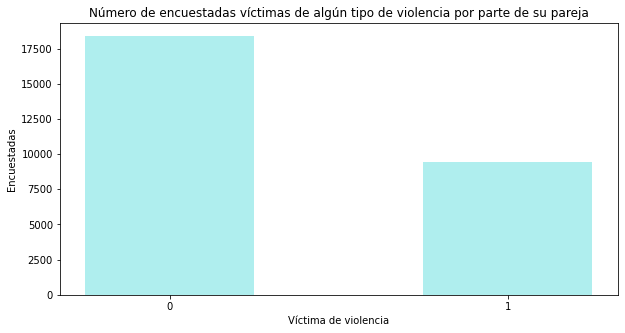

In [17]:
# Número de encuestadas que han sido víctimas de algún tipo de violencia por parte de su pareja
tab_plot=tab2.rename(columns = {'d_violencia':'victima_pareja', 'n_casos':'Total'})
# Convertir en str la dicotómica de 'victima_pareja'
tab_plot['victima_pareja'] = tab_plot.victima_pareja.astype(str)
# tamaño de la figura
fig = plt.figure(figsize = (10, 5))
#  Bar plot
plt.bar(tab_plot['victima_pareja'], # establecer variable del eje x
        tab_plot['Total'], # establecer variable del eje y
        color ='paleturquoise', # color de las barras
        width = 0.5)
# nombre de etiqueta eje x
plt.xlabel("Víctima de violencia")
# nombre de etiqueta ejey y
plt.ylabel("Encuestadas")
# título del gráfico
plt.title("Número de encuestadas víctimas de algún tipo de violencia por parte de su pareja")
plt.show()

In [18]:
# Tabla de frecuencias - casos de violencias menos severa
tot_D106 = data_final.groupby('D106')['D106'].count()
tot_D106=tot_D106.rename(None).to_frame().reset_index()# Resultado a dataframe
tot_D106.columns=['Victima','Violencia_menos_severa']# Cambio de nombre en las columnas
# Tabla de frecuencias - casos de violencias severa
tot_D107 = data_final.groupby('D107')['D107'].count()
tot_D107=tot_D107.rename(None).to_frame().reset_index()# Resultado a dataframe
tot_D107.columns=['Victima','Violencia_severa']# Cambio de nombre en las columnas
# Tabla de frecuencias - casos de violencias sexual
tot_D108 = data_final.groupby('D108')['D108'].count()
tot_D108=tot_D108.rename(None).to_frame().reset_index()# Resultado a dataframe
tot_D108.columns=['Victima','Violencia_sexual']# Cambio de nombre en las columnas
# Merge de las tablas de frecuencia según cada tipo
tab_plot = pd.merge(tot_D106, tot_D107, on='Victima', how='left')
tab_plot = pd.merge(tab_plot, tot_D108, on='Victima', how='left')
tab_plot['Victima'] = tab_plot.Victima.astype(str)
# Setear víctima como el índice
tab_plot = tab_plot.set_index('Victima')

Text(0, 0.5, 'Experimentó violencia')

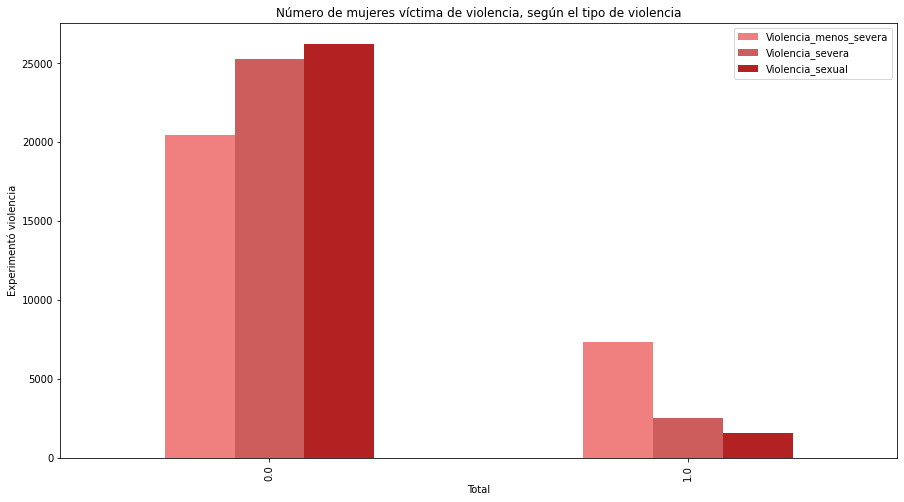

In [19]:
# Gráfico del número de mujeres víctima de violencia, según el tipo de violencia
tab_plot.plot(kind="bar",figsize=(15, 8), color = ['lightcoral','indianred','firebrick'])
plt.title("Número de mujeres víctima de violencia, según el tipo de violencia") # establecer título
plt.xlabel("Total") # etiqueta de eje x
plt.ylabel("Experimentó violencia") # etiqueta de eje y

### Parte b

In [20]:
data_final.columns

Index(['ID1', 'SREGION', 'SPROVIN', 'SDISTRI', 'CASEID', 'S108N', 'S119',
       'S119D', 'V218', 'V213', 'V225', 'S45D4', 'S45D5', 'S45P4', 'S45P5',
       'S45B0', 'S45B1', 'S45B2', 'S45B3', 'S45F1', 'S45F2', 'V501', 'V714',
       'D104', 'D106', 'D107', 'D108', 'violencia', 'y'],
      dtype='object')

#### Definición de predictores (X) y vector de target (y)

Nuestro variable a predecir (y) será una una dummy que toma el valor de 1 si es que la mujer ha sufrido algún tipo de violencia por parte de su compañero/esposo. Esta variable toma el valor de 0 si es que no ha sufrido violencia.

En cuanto a las variables que se usarán como predictores (X), serán las siguientes:

* SREGION: Región Natural (Categórica)
* S108N: Nivel educativo (Categórica)
* S119: Idioma o lengua materna (Categórica)
* S119D: Etnicidad (Categórica)
* V213: Está embarazada (Dummy)
* V501: Estado conyugal actual (Categórica)
* V714: Entrevistada actualmente trabaja  (Dummy)

Dado que no es intención del ejercicio complejizar el modelo, solo dichas variables fueron consideradas para el modelo de ML que será utilizado.

#### Limpieza de predictores a ser utilizados en el modelo de ML

In [21]:
categorical_vars = ['SREGION', 'S108N', 'S119', 'S119D', 'V213', 'V501', 'V714'] 

final_vars = ['SREGION', 'S108N', 'S119', 'S119D', 'V213', 'V501', 'V714', 'y']

In [22]:
#limitamos nuestro dataframe a solo las variables que serán utilizadas en el modelo de ML
data_ml = data_final[final_vars]

In [23]:
#convertimos las variables que deberian ser categóricas en "category"
for col in categorical_vars:
    data_ml[col] = data_ml[col].astype('category',copy=False)

In [24]:
#colocandole labels a las variables categóricas para mayor entendimiento
#Tambien reducimos el número de categorías para determinadas variables

#región natural:
data_ml.SREGION.replace({1.0:'lima', 2.0: 'costa', 3.0:'sierra',4.0:'selva'}, inplace = True)

#nivel educativo:
data_ml.S108N.replace({0.0:'ninguno', 1.0: 'primaria', 2.0:'secundaria',3.0:'superior',4.0:'superior',5.0:'superior'}, inplace = True)

#lengua materna:
data_ml.S119.replace({1.0:'nativo', 2.0: 'nativo', 3.0:'nativo',4.0:'nativo',5.0:'nativo',6.0:'nativo', 7.0:'nativo', 8.0:'nativo', 9.0:'nativo', 10.0:'castellano', 11.0:'extranjero', 12.0:'extranjero'}, inplace = True)

#etnicidad:
data_ml.S119D.replace({1.0:'nativo', 2.0: 'nativo', 3.0:'nativo',4.0:'nativo',5.0:'negro',6.0:'blanco', 7.0:'mestizo', 8.0:'otro', 98.0:'no_sabe'}, inplace = True)

#está embaraza:
data_ml.V213.replace({1.0:'si', 0.0: 'no'}, inplace = True)

#estado conyugal
data_ml.V501.replace({0.0:'no_casada', 1.0: 'casada', 2.0:'conviviente', 3.0:'viuda', 4.0:'divorciada',5.0:'no_viven_juntos'}, inplace = True)

#actualmente trabaja
data_ml.V714.replace({1.0:'si', 0.0: 'no'}, inplace = True)

In [25]:
#verificamos las categorías
for col in categorical_vars:
    print(data_ml[col].value_counts())

sierra    14068
costa     12699
selva     10856
lima       5514
Name: SREGION, dtype: int64
secundaria    21139
superior      12425
primaria       8982
ninguno         591
Name: S108N, dtype: int64
castellano    34581
nativo         8502
extranjero       54
Name: S119, dtype: int64
mestizo    18437
nativo     14176
negro       4960
blanco      3061
no_sabe     2118
otro         385
Name: S119D, dtype: int64
no    41940
si     1197
Name: V213, dtype: int64
conviviente        19920
no_casada          10956
casada              7272
no_viven_juntos     4868
viuda                 75
divorciada            46
Name: V501, dtype: int64
si    20507
no    19535
Name: V714, dtype: int64


#### Aplicando encoding en las variables categóricas 

In [26]:
import sklearn
#!pip install category_encoders
import category_encoders as ce

In [27]:
ce_OHE = ce.OneHotEncoder(cols=categorical_vars)

data_final = ce_OHE.fit_transform(data_ml)
data_final.head()

,SREGION_1,SREGION_2,SREGION_3,SREGION_4,S108N_1,S108N_2,S108N_3,S108N_4,S119_1,S119_2,...,V501_1,V501_2,V501_3,V501_4,V501_5,V501_6,V714_1,V714_2,V714_3,y
0,1,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0.0
1,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,<NA>
2,1,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,1,0,0,1.0
3,1,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,<NA>
4,1,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,1,0,<NA>


In [28]:
data_final.columns

Index(['SREGION_1', 'SREGION_2', 'SREGION_3', 'SREGION_4', 'S108N_1',
       'S108N_2', 'S108N_3', 'S108N_4', 'S119_1', 'S119_2', 'S119_3',
       'S119D_1', 'S119D_2', 'S119D_3', 'S119D_4', 'S119D_5', 'S119D_6',
       'V213_1', 'V213_2', 'V501_1', 'V501_2', 'V501_3', 'V501_4', 'V501_5',
       'V501_6', 'V714_1', 'V714_2', 'V714_3', 'y'],
      dtype='object')

#### Aplicando modelo de ML

In [29]:
from sklearn.linear_model import *
from sklearn.pipeline import *
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import *

In [30]:
#eliminamos los na de la variable target
data_final2 = data_final[data_final['y'].notna()]

In [31]:
len(data_final2)

27803

###### Secuencial

In [32]:
#Train-test splitting 
X_train, X_test, y_train, y_test = train_test_split(
    data_final2.iloc[:,range(0,len(data_final2.columns)-1)],
    data_final2['y'],
    test_size=0.3,
    random_state=175904)

print("Number of records: %d"%data_final2.shape[0])
data_final2[1:5]

Number of records: 27803


,SREGION_1,SREGION_2,SREGION_3,SREGION_4,S108N_1,S108N_2,S108N_3,S108N_4,S119_1,S119_2,...,V501_1,V501_2,V501_3,V501_4,V501_5,V501_6,V714_1,V714_2,V714_3,y
2,1,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,1,0,0,1.0
5,1,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0.0
6,1,0,0,0,1,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0.0
7,1,0,0,0,0,0,1,0,1,0,...,1,0,0,0,0,0,1,0,0,0.0


In [33]:
%%time 
#Definimos los parametros para correr el modelo lasso
grid_params = { 
    "lasso0__eps": [1e-3, 1e-4, 1e-5],
    "lasso0__n_alphas": [100, 250, 500]}

#corremos el lasso
lasso0 = LassoCV(max_iter=1000, n_alphas=300, n_jobs=15, random_state=175904)

#definimos el pipeline de lasso
pipe0  = Pipeline([("lasso0", lasso0)])

#seleccionamos el grid search usando cross validation
grid = GridSearchCV(estimator=pipe0, 
                    param_grid=grid_params, 
                    n_jobs=15, scoring="neg_mean_squared_error")

#fit del modelo
gridm = grid.fit(X_train, y_train)

Wall time: 19.5 s


In [34]:
#print de las métricas del grid search
print("Score: %f with metric '%s'\nThe best parameters are: %s"%(
    gridm.score(X_test, y_test), 
    grid.scoring,
    gridm.best_params_))

Score: -0.203793 with metric 'neg_mean_squared_error'
The best parameters are: {'lasso0__eps': 0.001, 'lasso0__n_alphas': 100}


In [35]:
%%time
#predicción 
gridm.predict(X_test)

Wall time: 2.99 ms


array([0.21711814, 0.65727759, 0.19576371, ..., 0.35043083, 0.3766837 ,
       0.33217405])

###### Paralelo

In [36]:
#Train-test splitting  usando dask
dX_train, dX_test, dy_train, dy_test = (
    dd.from_pandas(X_train, npartitions=3),
    dd.from_pandas(X_test, npartitions=3),
    dd.from_pandas(y_train, npartitions=3),
    dd.from_pandas(y_test, npartitions=3)
)

In [37]:
import dask_ml.model_selection as dms
#!pip install dask-ml

In [38]:
%%time 
#Definimos los parametros para correr el modelo lasso
grid_params = { 
    "lasso0__eps": [1e-3, 1e-4, 1e-5],
    "lasso0__n_alphas": [100, 250, 500]}

#corremos el lasso
lasso0 = LassoCV(max_iter=1000, n_alphas=300, n_jobs=15, random_state=175904)

#definimos el pipeline de lasso
pipe0  = Pipeline([("lasso0", lasso0)])

#seleccionamos el grid search usando cross validation y usando dask
dgrid = dms.GridSearchCV(estimator=pipe0, 
                    param_grid=grid_params, 
                    n_jobs=15, scoring="neg_mean_squared_error")

#fit del modelo usando dask
dgridm = dgrid.fit(dX_train, dy_train)

Wall time: 12.1 s


In [39]:
%%time
#predicción usando dask
y_hat = dX_test.map_partitions(dgridm.predict)
y_hat.compute()

Wall time: 1.01 s


array([0.64487621, 0.33497753, 0.22099631, ..., 0.28828227, 0.26217896,
       0.36648363])

#### Limitaciones y posibles extensiones

En cuanto a las limitaciones:
- A pesar de que inicialmente se planteaba utilizar variables predictoras de distintos módulos, al final, se han considerado un reducido número de predictores. Esto debido a que surgieron dificultades con el kernel de python al cargar bases de datos extensas.
- Se ha utilizado un modelo básico de predicción, dado la naturaleza del ejercicio. 
- Nuestro modelo lasso utilizado considera distintas interacciones entre los predictores. Sin embargo, no todas estas pueden ser interpretadas debido a la complejidad de su composición. 

En cuanto a posibles extensiones:

- Se propone extender el estudio a utilizar un modelo de double lasso o modelos de ML más precisos como redes neuronales.
- También se podrían utilizar un mayor número de predictores. Para esto, se utilizarían otros módulos más de la ENDES.